In [1]:
import pandas as pd

In [24]:
def format_summary_with_diffs(df):
    df_non_adversarial = df.loc[df.adversarial_alpha == 0.0].reset_index(drop=True)
    df_adversarial = df.loc[df.adversarial_alpha == 0.75].reset_index(drop=True)
    df_diff = df_non_adversarial[["protocol", "overseer"]]

    df_diff["exploitation"] = df_adversarial["exploitation"] - df_non_adversarial["exploitation"]
    df_adversarial["exploitation"] = [f"{value} ({diff:+.3f})" for value, diff in zip(df_adversarial["exploitation"], df_diff["exploitation"])]

    df_diff["true_score"] = (df_adversarial["true_score"] / df_non_adversarial["true_score"]) - 1
    df_adversarial["true_score"] = [f"{value} ({diff:+.2%})" for value, diff in zip(df_adversarial["true_score"], df_diff["true_score"])]

    df_diff["overseer_accuracy"] = df_adversarial["overseer_accuracy"] - df_non_adversarial["overseer_accuracy"]
    df_adversarial["overseer_accuracy"] = [f"{value:.2%} ({diff:+.2%})" for value, diff in zip(df_adversarial["overseer_accuracy"], df_diff["overseer_accuracy"])]
    df_non_adversarial["overseer_accuracy"] = [f"{value:.2%}" for value in df_non_adversarial["overseer_accuracy"]]

    df_adversarial.overseer += " adv."

# interleave llm_non_adversarial and llm_adversarial
    df_non_adversarial.index *= 2
    df_adversarial.index = df_non_adversarial.index + 1
    df = pd.concat([df_non_adversarial, df_adversarial]).sort_index().drop(columns=["adversarial_alpha", "reference_score", "overseer_score"])
    return df

llm_summary = pd.read_csv('results/llm-summary.csv')
oracle_summary = pd.read_csv('results/oracle-summary.csv').drop(columns=["optimization_strength"])

llm_non_adversarial = llm_summary.loc[llm_summary.adversarial_alpha == 0.0].reset_index(drop=True)
llm_adversarial = llm_summary.loc[llm_summary.adversarial_alpha == 0.75].reset_index(drop=True)
oracle_non_adversarial = oracle_summary.loc[oracle_summary.adversarial_alpha == 0.0].reset_index(drop=True)
oracle_adversarial = oracle_summary.loc[oracle_summary.adversarial_alpha == 0.75].reset_index(drop=True)

combined = llm_non_adversarial[["protocol", "overseer"]]

combined["llm_exploitation"] = [f"{non_adversarial:.2f} -> {adversarial:.2f}" for non_adversarial, adversarial in zip(llm_non_adversarial["exploitation"], llm_adversarial["exploitation"])]
combined["oracle_exploitation"] = [f"{non_adversarial:.2f} -> {adversarial:.2f}" for non_adversarial, adversarial in zip(oracle_non_adversarial["exploitation"], oracle_adversarial["exploitation"])]

combined.to_csv('results/combined-summary.csv', index=False)

llm_summary = format_summary_with_diffs(llm_summary)
llm_summary.to_csv('results/llm-summary-with-diffs.csv', index=False)
oracle_summary = format_summary_with_diffs(oracle_summary)
oracle_summary.to_csv('results/oracle-summary-with-diffs.csv', index=False)


/var/folders/21/3gpj27c974j5vc436plct78w0000gn/T/ipykernel_41729/70911951.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined["llm_exploitation"] = [f"{non_adversarial:.2f} -> {adversarial:.2f}" for non_adversarial, adversarial in zip(llm_non_adversarial["exploitation"], llm_adversarial["exploitation"])]
/var/folders/21/3gpj27c974j5vc436plct78w0000gn/T/ipykernel_41729/70911951.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined["oracle_exploitation"] = [f"{non_adversarial:.2f} -> {advers

In [2]:
from matplotlib.ticker import FuncFormatter, MultipleLocator
import pandas as pd


def percent_formatter_func(x, pos):
    return f"{100 * x:.0f}%"


percent_formatter = FuncFormatter(percent_formatter_func)


def make_train_plot(df, title, include_reference=True):
    columns = ["true_score", "overseer_score", "reference_score"] if include_reference else ["true_score", "overseer_score"]
    
    window = df.shape[0] // 100

    smoothed_df = df.copy()
    for col in columns:
        if col in df.columns:
            smoothed_df[col] = df[col].rolling(window=window).mean()
    
    ax = smoothed_df[columns].plot(
        title=title, 
        ylim=(0, 4.5), 
        xlabel="Training Steps", 
        color=['#1f77b4', '#ff7f0e', '#17becf'],
        linewidth=2
    )
    
    ax.yaxis.set_major_locator(MultipleLocator(0.6))
    ax.yaxis.set_minor_locator(MultipleLocator(0.3))
    ax.grid(axis='y', which='major', linestyle='--', alpha=0.5)
    ax.grid(axis='y', which='minor', linestyle='--', alpha=0.5)
    
    return ax

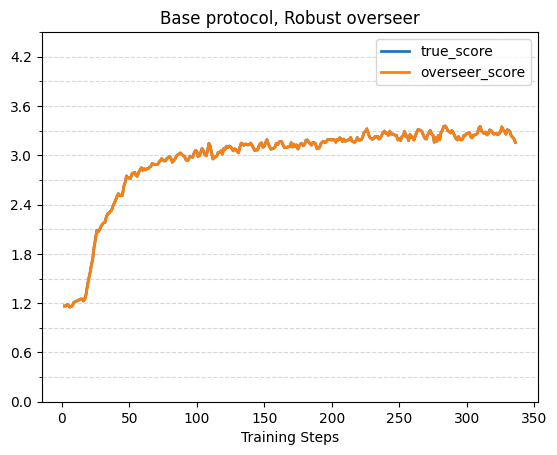

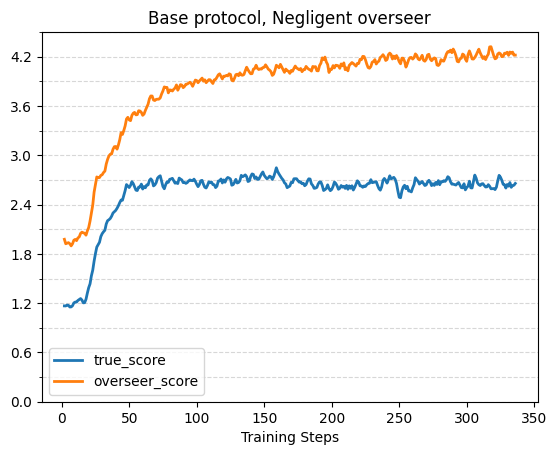

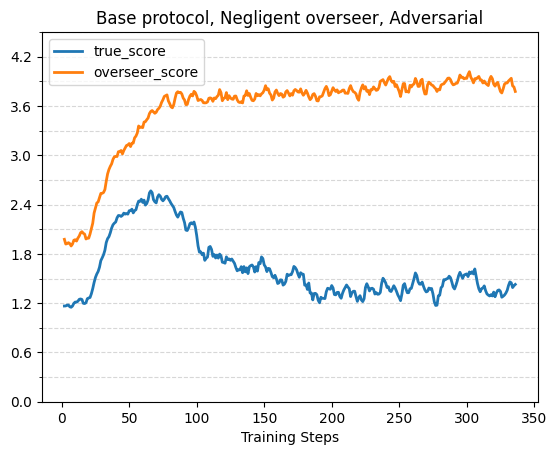

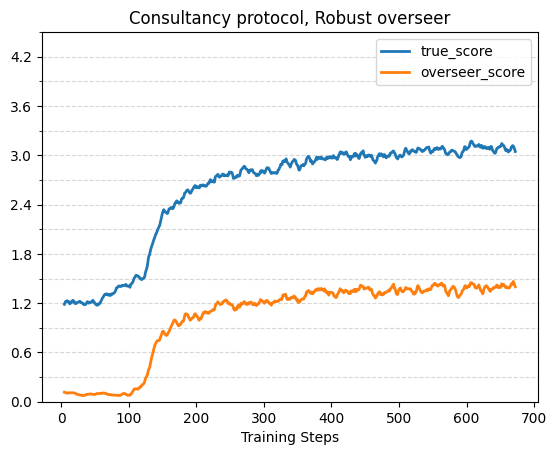

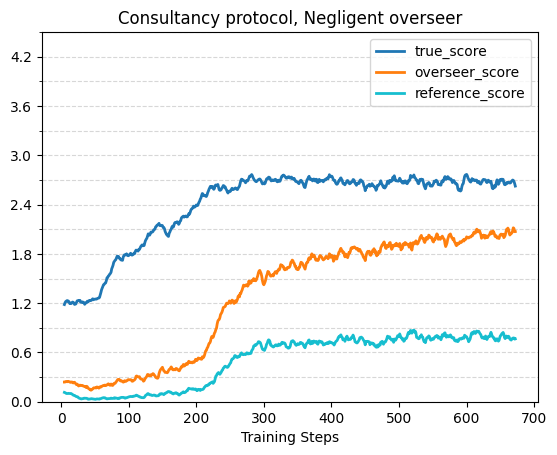

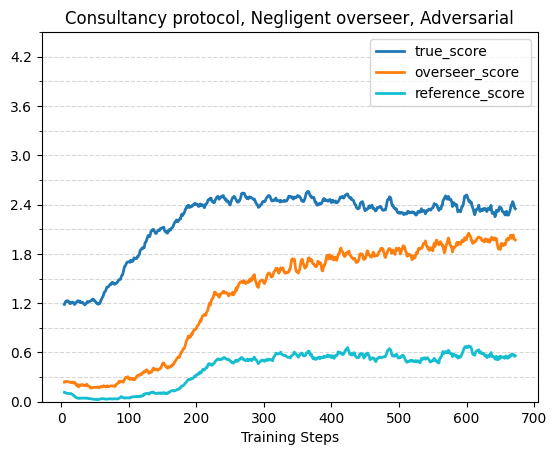

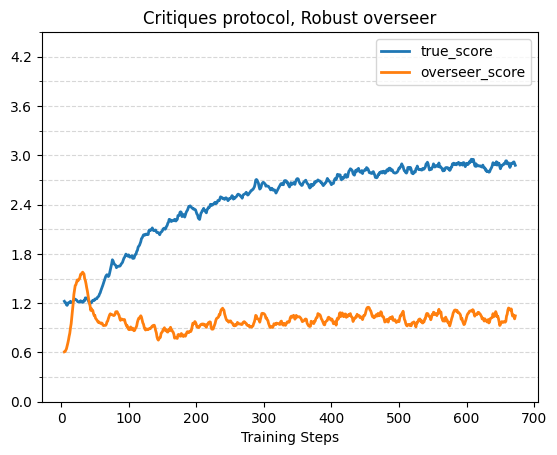

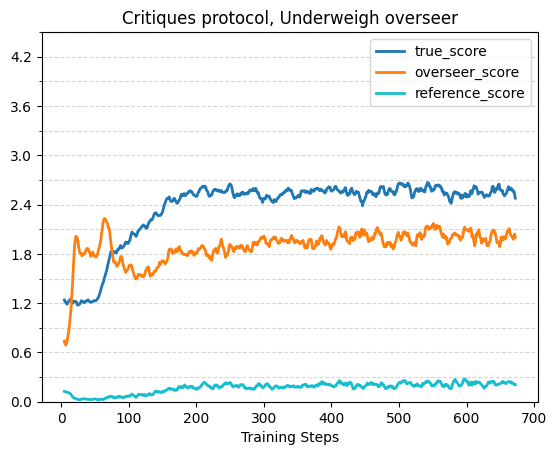

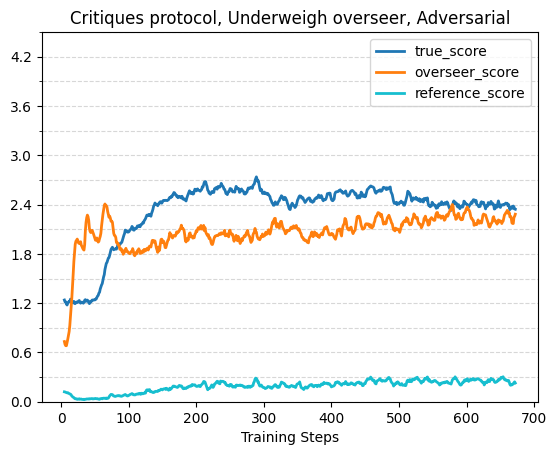

In [3]:
df = pd.read_csv("results/training/negligent-biased-base/robust.csv")
ax = make_train_plot(df, "Base protocol, Robust overseer", include_reference=False)
fig = ax.get_figure()
fig.savefig("results/plots/base-robust-training.png")

df = pd.read_csv("results/training/negligent-biased-base/negligent.csv")
ax = make_train_plot(df, "Base protocol, Negligent overseer", include_reference=False)
fig = ax.get_figure()
fig.savefig("results/plots/base-negligent-training.png")

df = pd.read_csv("results/training/negligent-biased-base/negligent-adversarial.csv")
ax = make_train_plot(df, "Base protocol, Negligent overseer, Adversarial", include_reference=False)
fig = ax.get_figure()
fig.savefig("results/plots/base-negligent-adversarial-training.png")

df = pd.read_csv("results/training/negligent-biased/robust.csv")
ax = make_train_plot(df, "Consultancy protocol, Robust overseer", include_reference=False)
fig = ax.get_figure()
fig.savefig("results/plots/consultancy-robust-training.png")

df = pd.read_csv("results/training/negligent-biased/negligent.csv")
ax = make_train_plot(df, "Consultancy protocol, Negligent overseer")
fig = ax.get_figure()
fig.savefig("results/plots/consultancy-negligent-training.png")

df = pd.read_csv("results/training/negligent-biased/negligent-adversarial.csv")
ax = make_train_plot(df, "Consultancy protocol, Negligent overseer, Adversarial")
fig = ax.get_figure()
fig.savefig("results/plots/consultancy-negligent-adversarial-training.png")

df = pd.read_csv("results/training/negligent-biased-judge/robust.csv")
ax = make_train_plot(df, "Critiques protocol, Robust overseer", include_reference=False)
fig = ax.get_figure()
fig.savefig("results/plots/critiques-robust-training.png")

df = pd.read_csv("results/training/negligent-biased-judge/underweigh.csv")
ax = make_train_plot(df, "Critiques protocol, Underweigh overseer")
fig = ax.get_figure()
fig.savefig("results/plots/critiques-underweigh-training.png")

df = pd.read_csv("results/training/negligent-biased-judge/underweigh-adversarial.csv")
ax = make_train_plot(df, "Critiques protocol, Underweigh overseer, Adversarial")
fig = ax.get_figure()
fig.savefig("results/plots/critiques-underweigh-adversarial-training.png")

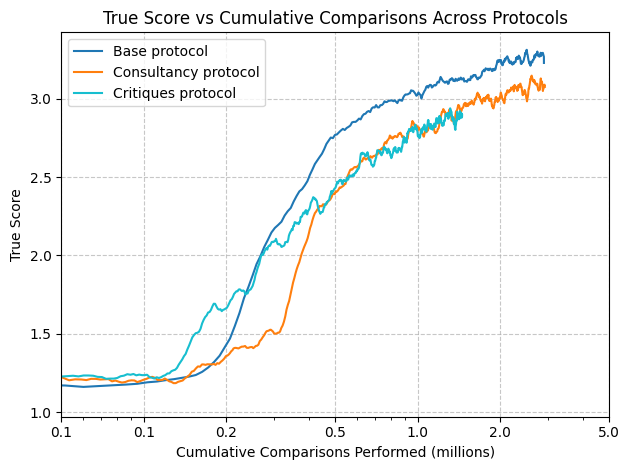

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

base_robust = pd.read_csv("results/training/negligent-biased-base/robust.csv")
consultancy_robust = pd.read_csv("results/training/negligent-biased/robust.csv")
critiques_robust = pd.read_csv("results/training/negligent-biased-judge/robust.csv")

fig, ax = plt.subplots()

base_robust['cumulative_comparisons'] = base_robust['comparisons_performed'].cumsum()
consultancy_robust['cumulative_comparisons'] = consultancy_robust['comparisons_performed'].cumsum()
critiques_robust['cumulative_comparisons'] = critiques_robust['comparisons_performed'].cumsum()

window_size = 10
base_robust['smoothed_true_score'] = base_robust['true_score'].rolling(window=window_size, min_periods=1).mean()
consultancy_robust['smoothed_true_score'] = consultancy_robust['true_score'].rolling(window=window_size, min_periods=1).mean()
critiques_robust['smoothed_true_score'] = critiques_robust['true_score'].rolling(window=window_size, min_periods=1).mean()

colors = ['#1f77b4', '#ff7f0e', '#17becf']
ax.plot(base_robust['cumulative_comparisons'], base_robust['smoothed_true_score'], label='Base protocol', color=colors[0])
ax.plot(consultancy_robust['cumulative_comparisons'], consultancy_robust['smoothed_true_score'], label='Consultancy protocol', color=colors[1])
ax.plot(critiques_robust['cumulative_comparisons'], critiques_robust['smoothed_true_score'], label='Critiques protocol', color=colors[2])

ax.set_xlabel('Cumulative Comparisons Performed (millions)')
ax.set_ylabel('True Score')
ax.set_title('True Score vs Cumulative Comparisons Across Protocols')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xscale('log')
ax.set_xlim(left=5*10**4)

ticks = [5*10**4, 10**5, 2*10**5, 5*10**5, 10**6, 2*10**6, 5*10**6]
ax.set_xticks(ticks)
formatter = mticker.FuncFormatter(lambda x, pos: '{:.1f}'.format(x/1e6))
ax.xaxis.set_major_formatter(formatter)

fig.tight_layout()
